The Australian DEM is 35GB, and hosted by the DEA [here](https://data.dea.ga.gov.au/?prefix=projects/elevation/ga_srtm_dem1sv1_0/)
AWS bucket name to use to access the data is `dea-public-data`

## Original Data Source

*SRTM-derived 1 Second Digital Elevation Models Version 1.0*

The 1 second Shuttle Radar Topography Mission (SRTM) Digital Elevation
Models Version 1.0 package comprises three surface models: the Digital
Elevation Model (DEM), the Smoothed Digital Elevation Model (DEM-S)
and the Hydrologically Enforced Digital Elevation Model (DEM-H).

### sources and guides
[DEA guide to accessing data from their public S3 bucket using STAC](https://docs.dea.ga.gov.au/guides/setup/gis/stac/)

[Downloading and streaming data using STAC metadata](https://docs.dea.ga.gov.au/notebooks/How_to_guides/Downloading_data_with_STAC/)

In [39]:
import os

# packages for widgets and interactive map:
import ipywidgets as widgets
from IPython.display import display, HTML
from ipyleaflet import Map, WidgetControl, GeoData
import io
import base64
import rioxarray
import xarray as xr
import xarray_leaflet
import matplotlib.pyplot as plt

from localtileserver import get_leaflet_tile_layer

#packages for geo-processing:
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import from_bounds
import xarray as xr
import xarray_leaflet

import pystac_client
import stackstac
import odc.stac
import pyproj
from dask.distributed import Client, LocalCluster
import pandas as pd

In [40]:
def convert_bounds(bbox, invert_y=False):
    """
    Helper method for changing bounding box representation to leaflet notation

    ``(lon1, lat1, lon2, lat2) -> ((lat1, lon1), (lat2, lon2))``
    """
    x1, y1, x2, y2 = bbox
    if invert_y:
        y1, y2 = y2, y1
    return ((y1, x1), (y2, x2))

1. Set environment variable for AWS and start a Dask client for parallel computation (needed for stackstac)
2. Read the boundary GeoJSON file and extract the bounding box
3. Open the STAC catalogs for DEM and RGB data
4. Define the collections for DEM and RGB data
5. Set the date range for the RGB data
6. Define spatial projection information

## environment and STAC setup

In [41]:
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'
client = Client()
#cluster = LocalCluster()

"""
If STAC service is down, try using direct link to the DEM-H geotiff file
"""
dem_href = 'https://dea-public-data.s3-ap-southeast-2.amazonaws.com/projects/elevation/ga_srtm_dem1sv1_0/dem1sv1_0.tif'


#catalog_dem = pystac_client.Client.open("https://explorer.sandbox.dea.ga.gov.au/stac/")
#collection_dem = ['ga_srtm_dem1sv1_0']

crs_string = "epsg:3857"
epsg = pyproj.CRS.from_string(crs_string).to_epsg()
resolution = 90 #added to resolve error "Failed to auto-guess CRS/resolution."


/opt/conda/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36055 instead
  warnings.warn(


## interactive map so users can upload aoi files

In [42]:
style = {'description_width': 'initial'}
uploader = widgets.FileUpload(
    description='Upload file',
    accept='.zip, .json, .geojson',
    multiple=False,
    button_style='primary',
    style=style,
)

submit = widgets.Button(description='Display AOI', button_style='success', tooltip='Click me', style=style)

reset = widgets.Button(description='Reset', button_style='warning', tooltip='Click me', style=style)

get_data = widgets.Button(description='Get data for AOI', button_style='primary', tooltip='Click me', style=style)


the center point and zoom of the map are currently hard coded. Need to be updated to "zoom to layer" so that the map centers on the area covered by the user-uploaded geojson.
Also note that the map center lat/long are in opposite order to how they are stored in a geojson so need to add line to swap x/y coords to be used.

In [43]:
Map = Map(height='500px', width='500px', center=(-29.2253, 116.26012), zoom=10) #note that the center coordinates are the opposite to what is stored in a geojson, you need to swap the lat/long

output_widget = widgets.Output(layout={'border': '1px solid black'})
output_control = WidgetControl(widget=output_widget, position='bottomright')
Map.add_control(output_control)

with output_widget:
    display(uploader)
    display(submit)
    display(get_data)
    display(reset)

In [44]:
geo_json = None

def get_vector(upload_widget):
    vector = None
    try:
        file = upload_widget.value[0]
        content = file['content']
        bytes_io = io.BytesIO(content)
        vector = gpd.read_file(bytes_io)

    except Exception as e:
        print(e)
    return vector


def submit_clicked(b):
    global geo_json
    try:
        fc = get_vector(uploader)
        geo_json = GeoData(geo_dataframe = fc)
        Map.add_layer(geo_json)
    except Exception as e:
        print(e)
    
submit.on_click(submit_clicked)


def reset_clicked(b):
    global geo_json  # Declare geo_json as global so that we can access it
    output_widget.clear_output()
    with output_widget:
        display(uploader)
        display(submit)
        display(get_data)
        display(reset)
    uploader.value[0].clear()
    uploader._counter = 0
    if geo_json is not None:  # If a GeoData layer has been added to the map
        Map.remove_layer(geo_json)  # Remove the GeoData layer from the map
        geo_json = None  # Reset the reference to the GeoData layer

reset.on_click(reset_clicked)


## using uploaded aoi to get DEM

Alternative fetch DEM using direct href instead of doing a stac search because the DEA stac endpoint is having issues:

In [45]:
import tempfile
test_dem = None


def create_download_link(output_filename, title="Download GeoTIFF", filename="data.tif"):
    data = open(output_filename, "rb").read()
    b64 = base64.b64encode(data).decode()

    html = f'<a download="{filename}" href="data:application/octet-stream;base64,{b64}" target="_blank">{title}</a>'
    return HTML(html)

def get_data_clicked(b):
    global test_dem
    fc = get_vector(uploader) #don't use the geoData global variable, use the geodataframe
    bbox = list(fc.total_bounds)
     
    with rasterio.open(dem_href) as dem_data:
        # Read a window of data from the band
        data = dem_data.read(1,window=from_bounds(*bbox, transform=dem_data.transform),masked=True)
    test_dem = data
    
    output_filename = "clipped_raster.tif"
    with rasterio.open(
        output_filename,
        'w',
        driver='GTiff',
        height=test_dem.shape[1],
        width=test_dem.shape[2],
        count=test_dem.shape[0],
        dtype=test_dem.dtype,
        crs=test_dem.crs,
        transform=test_dem.transform,
    ) as dst:
        dst.write(test_dem)
    
    #dem = rioxarray.open_rasterio(output_filename)
    #dem = test_dem.rio.reproject('EPSG:4326')
    #dem = test_dem.sel(band=1)

get_data.on_click(get_data_clicked)
    



Download the fetched DEM raster:

In [46]:
# import tempfile
# test_dem = None
# # FILEPATH: /workspaces/data-notebooks/notebooks/evergreen-resources/get-elevation-data-for-aoi.ipynb
# #this cell is for the get_data button

# def create_download_link(output_filename, title="Download GeoTIFF", filename="data.tif"):
#     data = open(output_filename, "rb").read()
#     b64 = base64.b64encode(data).decode()

#     html = f'<a download="{filename}" href="data:application/octet-stream;base64,{b64}" target="_blank">{title}</a>'
#     return HTML(html)

# def get_data(b):
#     global test_dem
#     fc = get_vector(uploader) #don't use the geoData global variable, use the geodataframe
#     bbox = list(fc.total_bounds)
#     ds_dem = catalog_dem.search(
#     bbox=bbox, 
#     collections=collection_dem)

#     items = ds_dem.item_collection()
#     bands_of_interest = 'dem_h'

#     da = stackstac.stack(
#         items,
#         assets=[bands_of_interest],
#         epsg=epsg,
#         resolution=resolution,
#         bounds_latlon=bbox# <-- use Dask
#     ).isel(time=0)
#     da = da.compute()
#     test_dem = da
    
#     #da.leaflet.plot(Map, colormap=plt.cm.terrain)
    
#     # output_filename = "clipped_raster.tif"
#     # with rasterio.open(
#     #     output_filename,
#     #     'w',
#     #     driver='GTiff',
#     #     height=da.shape[1],
#     #     width=da.shape[2],
#     #     count=da.shape[0],
#     #     dtype=da.dtype,
#     #     crs=da.crs,
#     #     transform=da.transform,
#     # ) as dst:
#     #     dst.write(da)
        
#     # temp_raster = rioxarray.open_rasterio(output_filename)
#     # temp_raster_4326 = temp_raster.rio.reproject('EPSG:4326')
#     # temp_raster_4326_mapband = temp_raster_4326.sel(band=1)

#     # temp_raster_4326_mapband.leaflet.plot(Map, colormap=plt.cm.terrain)

#     #download_button = create_download_link(output_filename, title="Download GeoTIFF", filename="demdata.tif")

#     return da
    



## This section of code uses a hardcoded geojson to test. Remove once widget version is working.

In [47]:
geom_gpd = gpd.read_file('data/temp/dissolved-boundaries.geojson')
bbox = list(geom_gpd.total_bounds)
bbox

[116.26012130269045,
 -29.307384715430175,
 116.3875862387774,
 -29.220237788279107]

Search for DEM data in the STAC catalog. Note that there is no timeframe filtering here because there is only 1, perpetual DEM in this catalog. If you add a timeframe you will get 0 results.
There are 3 assets in this collection: `dem`, `dem_s` and `dem_h`. All three are based on the NASA SRTM elevation data, so just use `dem_h`.
We will also get the url for the `dem_h` COG, so we can display it on a leafmap later on.

In [48]:
# ds_dem = catalog_dem.search(
#     bbox=bbox, 
#     collections=collection_dem)

# items = ds_dem.item_collection()
# print(f"Found {len(items)} items in the {collection_dem}")

In [49]:
# first_item = items.items[0]
# all_bands = list(first_item.assets.keys())
# print("Assets available:")
# print(*all_bands, sep=', ')

In [50]:
# bands_of_interest = 'dem_h'

# da = stackstac.stack(
#     items,
#     assets=[bands_of_interest],
#     epsg=epsg,
#     resolution=resolution,
#     bounds_latlon=bbox# <-- use Dask
# ).isel(time=0)
# da

Stack the DEM data, specifying the spatial bounds and desired resolution

One thing to watch out for with stackstac.stack is that you will wind up with a distinct time coordinate for each STAC item that you pass in. To achieve the intuitive representation of the data, you need to flatten the DataArray with respect to day.
Note: if you are only reading a single STAC item, stackstac.mosaic will inadvertently reduce your data along the band dimension (which is definitely not what you want!), hence the conditional statement checking for more than one time coordinate value.
[from here](https://hrodmn.dev/posts/stackstac/)

Here we are getting around the problem by using `isel` to select the first time epoch, as there is only one. A different approach will be needed if working with data across timeframes.

In [51]:
#da = da.compute()
# da.plot()

Save the selected DEM data as a GeoTIFF file

In [70]:
with rasterio.open(dem_href) as dem_data:
        # Read a window of data from the band
        #data = dem_data.read(window=from_bounds(*bbox, transform=dem_data.transform))
        data = dem_data.read()



MemoryError: Unable to allocate 67.3 GiB for an array with shape (1, 122400, 147600) and data type float32

In [65]:

output_filename = "data/temp/clipped_raster.tif"
with rasterio.open(
    output_filename,
    'w',
    driver='GTiff',
    height=test_dem.shape[0],
    width=test_dem.shape[1],
    count=test_dem.shape[0],
    dtype=test_dem.dtype,
    crs=test_dem.crs,
    transform=test_dem.transform,
) as dst:
    dst.write(test_dem)

AttributeError: 'numpy.ndarray' object has no attribute 'crs'

In [ ]:
# # Define the filename for the reprojected raster
# reprojected_filename = "data/temp/reprojected_raster.tif"

# # Open the original clipped raster
# with rasterio.open(output_filename) as src:
#     # Define the transform and dimensions for the new raster
#     transform, width, height = calculate_default_transform(
#         src.crs, 'EPSG:4326', src.width, src.height, *src.bounds)
    
#     # Define the metadata for the new raster
#     kwargs = src.meta.copy()
#     kwargs.update({
#         'crs': 'EPSG:4326',
#         'transform': transform,
#         'width': width,
#         'height': height
#     })

#     # Create and write the reprojected raster
#     with rasterio.open(reprojected_filename, 'w', **kwargs) as dst:
#         for i in range(1, src.count + 1):
#             reproject(
#                 source=rasterio.band(src, i),
#                 destination=rasterio.band(dst, i),
#                 src_transform=src.transform,
#                 src_crs=src.crs,
#                 dst_transform=transform,
#                 dst_crs='EPSG:4326',
#                 resampling=Resampling.nearest)

In [ ]:
# dem_client = TileClient('data/temp/reprojected_raster.tif')
# dem_client.thumbnail(palette="gist_earth")

## put map cell at bottom of notebook

In [ ]:
Map

Map(center=[-29.2253, 116.26012], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

In [ ]:
#display(download_button)

In [ ]:
print(test_dem)

[[315.922607421875 314.9764404296875 312.02813720703125 ...
  274.00909423828125 273.0329284667969 275.0523376464844]
 [315.9639892578125 315.0064697265625 313.0448303222656 ...
  268.8581237792969 266.8821716308594 272.90594482421875]
 [314.9993896484375 316.0278625488281 315.05120849609375 ...
  266.70526123046875 265.73004150390625 270.75927734375]
 ...
 [323.9615173339844 325.9654235839844 327.9700622558594 ...
  292.36199951171875 293.24822998046875 294.1274108886719]
 [323.029296875 325.03564453125 326.0388488769531 ... 292.4123229980469
  293.329833984375 293.22662353515625]
 [322.08807373046875 326.0996398925781 326.1047668457031 ...
  291.4022216796875 292.36663818359375 292.30267333984375]]


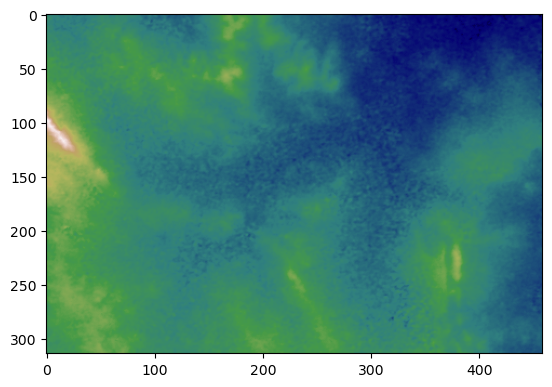

In [ ]:
#plt.imshow(test_dem, cmap="gist_earth")